# Machine Learning Train pipeline

1. Use different data timewindow

2. Show distribution and plots for training set

2. Run it in different machine learning model

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn import tree, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from sklearn.metrics import \
    classification_report, \
    plot_confusion_matrix, \
    confusion_matrix, \
    roc_curve, \
    auc, \
    f1_score, accuracy_score, recall_score, precision_score

## Define Functions and Consts

In [2]:
timewindows = [1, 3, 5, 10, 15, 20, 30]


In [3]:
def load_data(path) -> pd.DataFrame:
    df = pd.read_csv(path)
    return df

def plot_ROC(y_test, y_pred, plt_config):    
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=plt_config['figsize'])
        plt.title('ROC')
        plt.plot(fpr, tpr, 'b', label='ROC-AUC = %0.2f' % roc_auc)
        plt.plot([0,1], [0,1], 'y--', label='baseline')

        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc='best')
        plt.show()

def decisionTreeTrain(X_train, y_train, max_depth):
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    return clf

def randomForestTrain(X_train, y_train, max_depth):
    clf = RandomForestClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    return clf

def GMMTrain(X_train, n):
    clf =  GaussianMixture(n_components=n)
    clf.fit(X_train)
    return clf

def SVMTrain(X_train, y_train):
    svmclf = make_pipeline(preprocessing.StandardScaler(), SVC(kernel = 'rbf', gamma='auto'))
    svmclf.fit(X_train, y_train)
    return svmclf

def KNNTrain(X_train, y_train):
    knnclf = KNeighborsClassifier()
    knnclf.fit(X_train, y_train)
    return knnclf

def scalar_normalize(X_train, X_test):
    min_max_scalar = preprocessing.MinMaxScaler()
    X_train_minmax = min_max_scalar.fit_transform(X_train)
    X_test_minmax = min_max_scalar.transform(X_test)
    X_train_scaled = preprocessing.scale(X_train_minmax)
    X_test_scaled = preprocessing.scale(X_test_minmax)
    X_train_normalized = preprocessing.normalize(X_train_scaled, norm='l2')
    X_test_normalized = preprocessing.normalize(X_test_scaled, norm='l2')
    return X_train_normalized, X_test_normalized


In [4]:
def load_windows_data():
    dfs = []
    for t in tqdm(timewindows, desc="Loading Data"):
        path = "../csv_data/user_1_timewindow"+str(t)+".csv"
        dfs.append(load_data(path))
    return dfs

def preprocess_pipeline(dfs):
    ret = []
    for df in tqdm(dfs, desc="Preprocessing"):
        df = df.fillna(-10000)
        # df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
        df = df.replace((np.inf, -np.inf), 0).reset_index(drop=True)
        ret.append(df)
    return ret

def train_test_split_pipeline(dfs, test_size=0.3):
    ret = []
    for df in tqdm(dfs, desc="Spliting"):
        data_X = df.drop(columns = ['timestamp', 'class'])
        data_y = df['class']
        binary_data_y = data_y.copy()
        binary_data_y[binary_data_y>0] = 1
        X_train, X_test, y_train, y_test = train_test_split(data_X, binary_data_y, test_size=test_size)
        ret.append([X_train, X_test, y_train, y_test])
    return ret

def predict_scores(y_true, y_pred):
    accuracy, recall, f1_s = accuracy_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)
    return accuracy, recall, f1_s

def plot_timewindow_figure(scores, method):
    [accuracy_scores, recall_scores, f1_scores] = scores
    x = timewindows

    plt.plot(x, accuracy_scores, color='r', label='Accuracy')
    plt.plot(x, recall_scores, color='g', label='Recall')
    plt.plot(x, f1_scores, color='b', label='F1 Score')
    plt.xlabel('Time Window')
    plt.ylabel('Score')
    plt.title(method)
    plt.legend(loc="best")
    plt.show()

def prediction_pipeline(data, models):
    clfs = models
    accuracy_scores = []
    recall_scores = []
    f1_scores = []
    for index, [X_train, X_test, y_train, y_test] in enumerate(tqdm(data, desc="Evaluating")):
        clf = clfs[index]
        y_hat = clf.predict(X_test)
        accuracy, recall, f1_s = predict_scores(y_test, y_hat)
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        f1_scores.append(f1_s)
    return accuracy_scores, recall_scores, f1_scores

def plot_pipeline(scores, method):
    plot_timewindow_figure(scores, method)

def data_preparation_pipeline():
    dfs = load_windows_data()
    dfs = preprocess_pipeline(dfs)
    data = train_test_split_pipeline(dfs, test_size=0.3)
    return data



## Basic information about Datasets

Preprocessing: 100%|██████████| 7/7 [00:00<00:00, 206.44it/s]
Plotting: 7it [00:00, 64.99it/s]


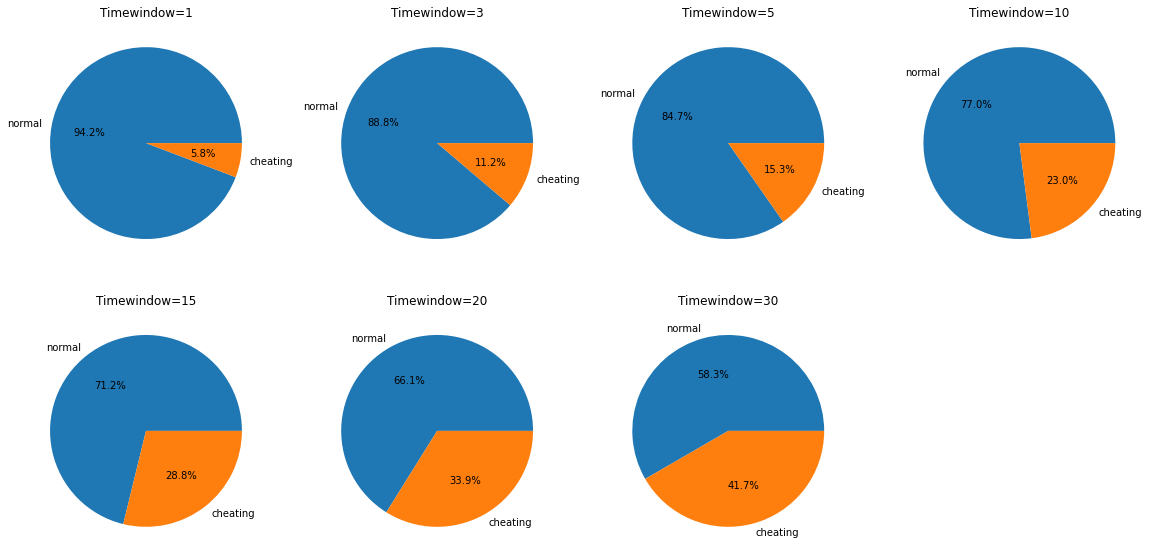

In [5]:
dfs = load_windows_data()
dfs = preprocess_pipeline(dfs)

fig = plt.figure(facecolor='white',figsize=(20, 15))

for index, df in tqdm(enumerate(dfs), "Plotting"):
    cts = df.value_counts(df['class'])
    eplodes = ['normal', 'cheat']
    plt.subplot(3, 4, index+1)
    plt.title("Timewindow="+str(timewindows[index]))
    plt.pie([cts[0], cts[2]], labels=['normal', 'cheating'], autopct='%1.1f%%')
    
plt.show()

## Supervised Learning

### 1. Decision Tree

In [6]:
def decision_tree_pipeLine():
    data = data_preparation_pipeline()
    clfs = []
    # training
    for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Training"):
        clf = decisionTreeTrain(X_train, y_train, 4)
        clfs.append(clf)
    # testing
    accuracy_scores, recall_scores, f1_scores = prediction_pipeline(data, clfs)
    plot_pipeline([accuracy_scores, recall_scores, f1_scores], method="Decision Tree")

Evaluating: 100%|██████████| 7/7 [00:00<00:00, 175.47it/s]


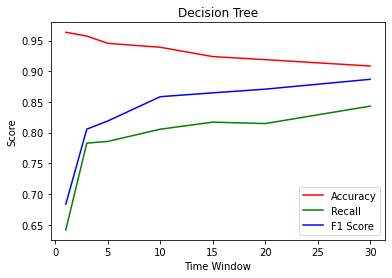

In [7]:
max_depths = [4]
decision_tree_pipeLine()

### 2. Random Forest

In [8]:
def random_forest_pipeLine():
    data = data_preparation_pipeline()
    clfs = []
    # training
    for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Training"):
        clf = randomForestTrain(X_train, y_train, 4)
        clfs.append(clf)
    # testing
    accuracy_scores, recall_scores, f1_scores = prediction_pipeline(data, clfs)
    plot_pipeline([accuracy_scores, recall_scores, f1_scores], method="Random Forest")

Evaluating: 100%|██████████| 7/7 [00:00<00:00, 27.10it/s]


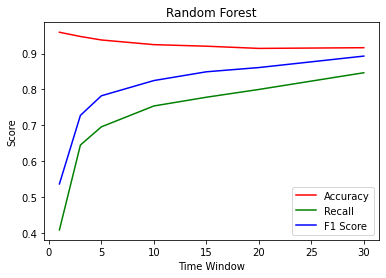

In [9]:
max_depths = [4]
random_forest_pipeLine()

### 3. Support Vector Machine(SVM)

In [10]:
def svm_pipeLine():
    data = data_preparation_pipeline()
    clfs = []
    # training
    for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Training"):
        clf = SVMTrain(X_train, y_train)
        clfs.append(clf)
    # testing
    accuracy_scores, recall_scores, f1_scores = prediction_pipeline(data, clfs)
    plot_pipeline([accuracy_scores, recall_scores, f1_scores], method="SVM")

Evaluating: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


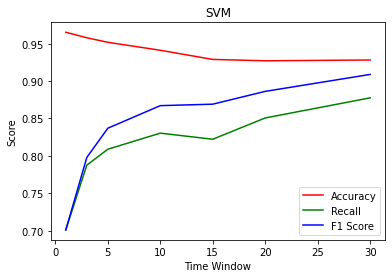

In [11]:
svm_pipeLine()

### 4. KNN

In [12]:
def KNN_pipeLine():
    data = data_preparation_pipeline()
    clfs = []
    # training
    for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Training"):
        clf = KNNTrain(X_train, y_train)
        clfs.append(clf)
    # testing
    accuracy_scores, recall_scores, f1_scores = prediction_pipeline(data, clfs)
    plot_pipeline([accuracy_scores, recall_scores, f1_scores], method="KNN")

Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]


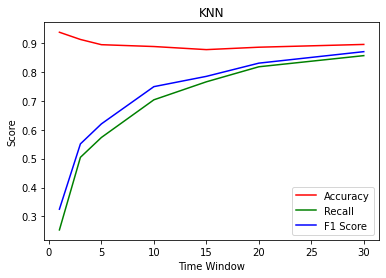

In [13]:
KNN_pipeLine()

## Semi-supervised Learning
### 5. GMM 

In [14]:
def GMM_pipeline(n):
    data = data_preparation_pipeline()
    features = ['average_mouse_speed', 'useful', 'useless']
    clfs = []
    accuracy_scores = []
    recall_scores = []
    f1_scores =[]
    for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Training and evaluating"):
        X_train['Class']= y_train
        train = X_train[X_train['Class']==1]
        X_test = X_test[features]
        X_test['Class']= y_test
        valid, test = train_test_split(X_test, test_size=0.5)
        gmm = GMMTrain(train[features], n)
        print("train set score: ", gmm.score(train[features]))
        print("valid_n score: ", gmm.score(valid[valid['Class']==0].drop('Class', axis = 1)))
        print("valid_a score: ", gmm.score(valid[valid['Class']==1].drop('Class', axis = 1)))
        tresholds = np.linspace(-100, 0, 100)
        scores = []
        for treshold in tresholds:
            y_hat = (gmm.score_samples(valid[features]) < treshold).astype(int)
            scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
            precision_score(y_pred=y_hat, y_true=valid['Class'].values),
            f1_score(y_pred=y_hat, y_true=valid['Class'].values)])
        scores = np.array(scores)
        best_threshold = tresholds[scores[:, 2].argmax()]
        y_hat = (gmm.score_samples(test[features]) < best_threshold).astype(int)
        accuracy_scores.append(accuracy_score(y_pred=y_hat, y_true=test['Class'].values))
        recall_scores.append(recall_score(y_pred=y_hat, y_true=test['Class'].values))
        f1_scores.append(f1_score(y_pred=y_hat, y_true=test['Class'].values))
    plot_pipeline([accuracy_scores, recall_scores, f1_scores], method="GMM")
    

when n =  1


Training and evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

train set score:  -8.488421021032389
valid_n score:  -8.718832450093428
valid_a score:  -8.191179770536907


Training and evaluating:  14%|█▍        | 1/7 [00:00<00:03,  1.80it/s]

train set score:  -9.689387954145918
valid_n score:  -10.30354435833527
valid_a score:  -9.828841813285464


Training and evaluating:  29%|██▊       | 2/7 [00:01<00:02,  1.84it/s]

train set score:  -10.251971730973331
valid_n score:  -11.023139153305305
valid_a score:  -10.321963699766723


Training and evaluating:  43%|████▎     | 3/7 [00:01<00:02,  1.84it/s]

train set score:  -11.084930578255333
valid_n score:  -11.839644860309424
valid_a score:  -11.097720628358712


Training and evaluating:  57%|█████▋    | 4/7 [00:02<00:01,  1.79it/s]

train set score:  -11.54225023706798
valid_n score:  -12.31747295501714
valid_a score:  -11.591065313662577


Training and evaluating:  71%|███████▏  | 5/7 [00:02<00:01,  1.79it/s]

train set score:  -11.882244911586849
valid_n score:  -12.626829444083915
valid_a score:  -11.84377405555197


Training and evaluating:  86%|████████▌ | 6/7 [00:03<00:00,  1.82it/s]

train set score:  -12.371439400276824
valid_n score:  -13.08431287271788
valid_a score:  -12.275432814343237


Training and evaluating: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


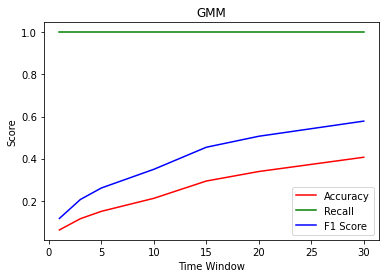

when n =  2


Training and evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

train set score:  -6.915809361081383
valid_n score:  -7.701304553762945
valid_a score:  -7.168318589251472


Training and evaluating:  14%|█▍        | 1/7 [00:00<00:03,  1.84it/s]

train set score:  -8.908402463140835
valid_n score:  -9.617655343354471
valid_a score:  -8.933563044736443


Training and evaluating:  29%|██▊       | 2/7 [00:01<00:02,  1.80it/s]

train set score:  -9.792155272075632
valid_n score:  -10.530744040342034
valid_a score:  -9.782629840775002


Training and evaluating:  43%|████▎     | 3/7 [00:01<00:02,  1.76it/s]

train set score:  -10.811954318370619
valid_n score:  -11.555335317027362
valid_a score:  -10.714039366071363


Training and evaluating:  57%|█████▋    | 4/7 [00:02<00:01,  1.75it/s]

train set score:  -11.279965498475372
valid_n score:  -12.074626875234179
valid_a score:  -11.346719917423055


Training and evaluating:  71%|███████▏  | 5/7 [00:02<00:01,  1.75it/s]

train set score:  -11.67115647023547
valid_n score:  -12.446053700146944
valid_a score:  -11.639231616226168


Training and evaluating:  86%|████████▌ | 6/7 [00:03<00:00,  1.70it/s]

train set score:  -12.168414131261937
valid_n score:  -12.724803811327785
valid_a score:  -12.205184373247008


Training and evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


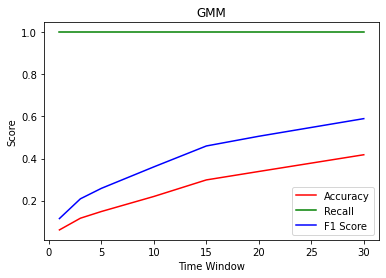

when n =  3


Training and evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

train set score:  -6.578083366380929
valid_n score:  -7.3373902036651915
valid_a score:  -7.218296722675341


Training and evaluating:  14%|█▍        | 1/7 [00:00<00:03,  1.80it/s]

train set score:  -8.807669318808239
valid_n score:  -9.378064742836958
valid_a score:  -8.876090184794098


Training and evaluating:  29%|██▊       | 2/7 [00:01<00:02,  1.75it/s]

train set score:  -9.658211151394026
valid_n score:  -10.431975542764652
valid_a score:  -9.727681053991562


Training and evaluating:  43%|████▎     | 3/7 [00:01<00:02,  1.75it/s]

train set score:  -10.705488234574839
valid_n score:  -11.518550774850226
valid_a score:  -10.705661512817908


Training and evaluating:  57%|█████▋    | 4/7 [00:02<00:01,  1.71it/s]

train set score:  -11.255109284961673
valid_n score:  -12.086406527024858
valid_a score:  -11.232545912972048


Training and evaluating:  71%|███████▏  | 5/7 [00:02<00:01,  1.67it/s]

train set score:  -11.593647402576453
valid_n score:  -12.394693983903707
valid_a score:  -11.616127739675466


Training and evaluating:  86%|████████▌ | 6/7 [00:03<00:00,  1.69it/s]

train set score:  -12.11386848813741
valid_n score:  -12.598652768730272
valid_a score:  -12.067992941779252


Training and evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


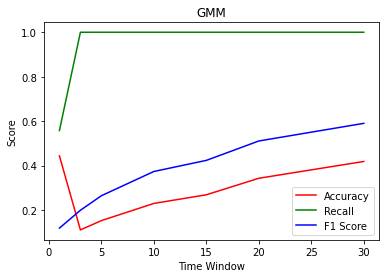

when n =  4


Training and evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

train set score:  -6.577759820307804
valid_n score:  -7.264118423061768
valid_a score:  -6.98967814014334


Training and evaluating:  14%|█▍        | 1/7 [00:00<00:03,  1.79it/s]

train set score:  -8.734685708365978
valid_n score:  -9.33262361776609
valid_a score:  -8.704855092627962


Training and evaluating:  29%|██▊       | 2/7 [00:01<00:02,  1.75it/s]

train set score:  -9.56526883153472
valid_n score:  -10.290147172663028
valid_a score:  -9.834385662853578


Training and evaluating:  43%|████▎     | 3/7 [00:01<00:02,  1.75it/s]

train set score:  -10.653571093266645
valid_n score:  -11.41494331158497
valid_a score:  -10.76720568494957


Training and evaluating:  57%|█████▋    | 4/7 [00:02<00:01,  1.70it/s]

train set score:  -11.209659702260785
valid_n score:  -12.12637893202683
valid_a score:  -11.221207110112502


Training and evaluating:  71%|███████▏  | 5/7 [00:02<00:01,  1.67it/s]

train set score:  -11.595490299553324
valid_n score:  -12.217857320047205
valid_a score:  -11.679453520272089


Training and evaluating:  86%|████████▌ | 6/7 [00:03<00:00,  1.67it/s]

train set score:  -12.0375723842295
valid_n score:  -12.3271040147081
valid_a score:  -12.087994198864758


Training and evaluating: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


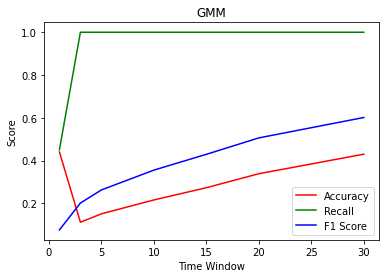

In [15]:
for n in range(1,5):
    print("when n = ", n)
    GMM_pipeline(n)

Check features: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


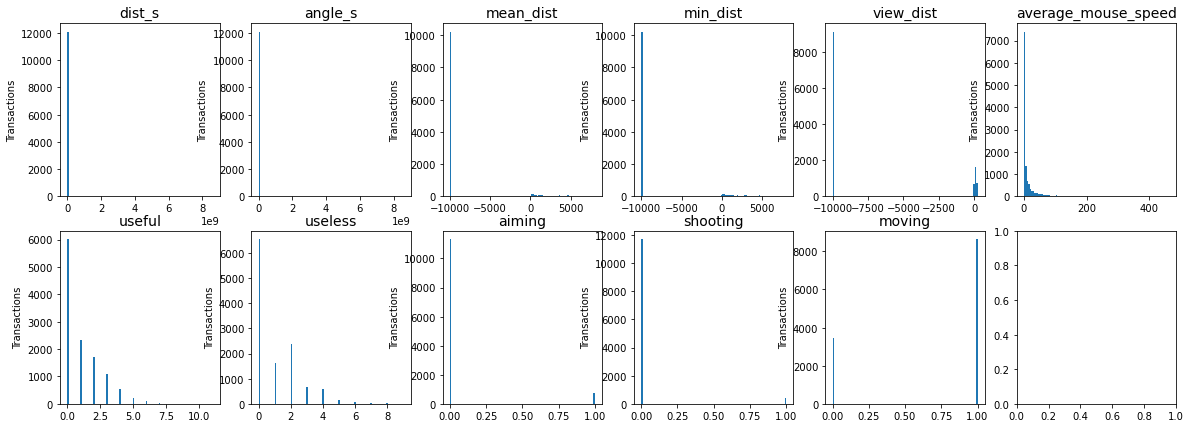

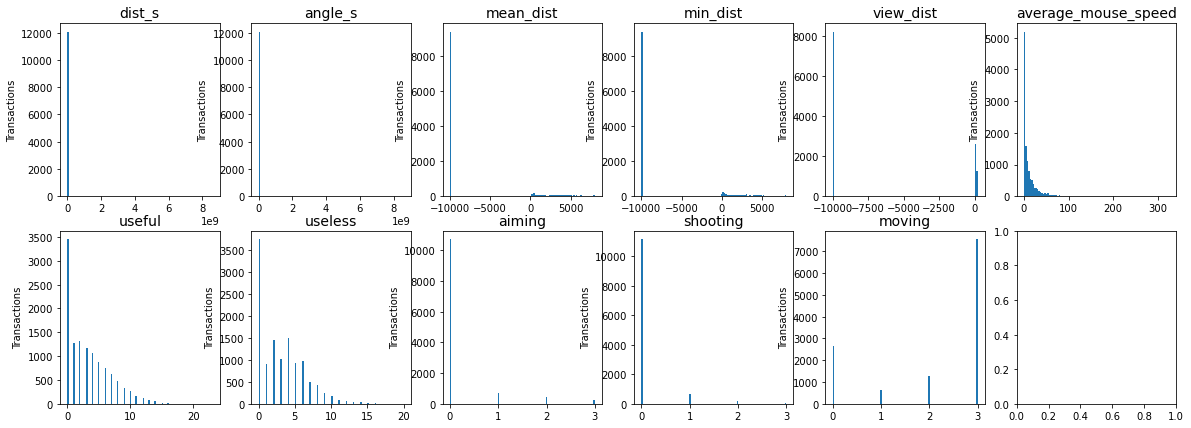

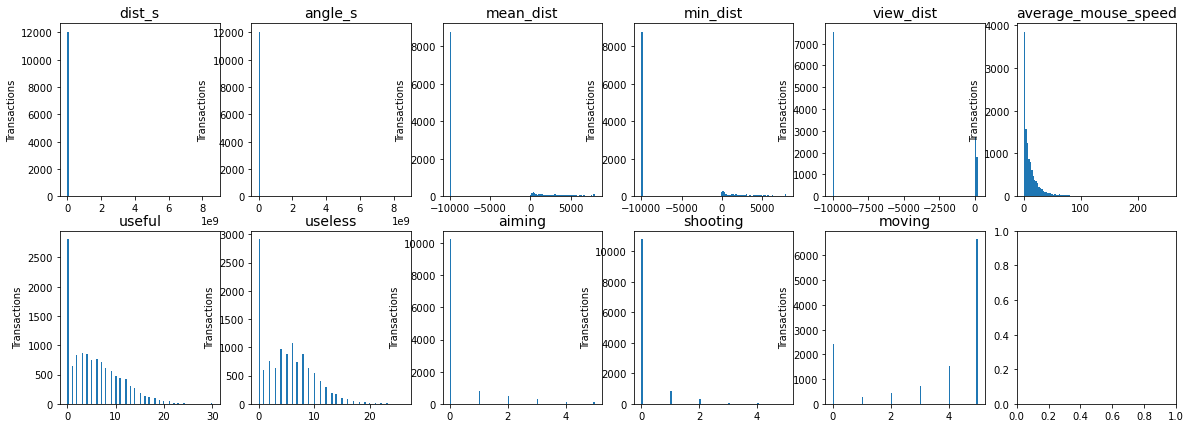

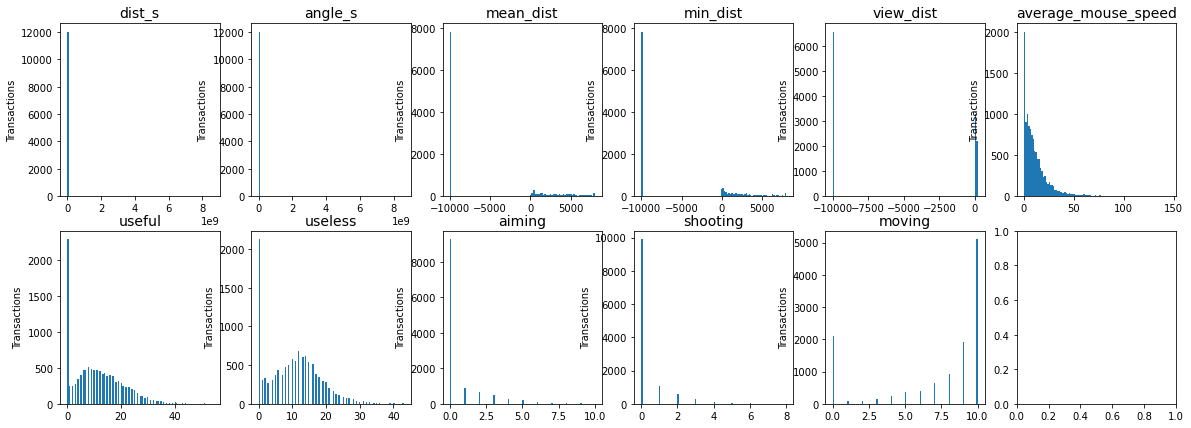

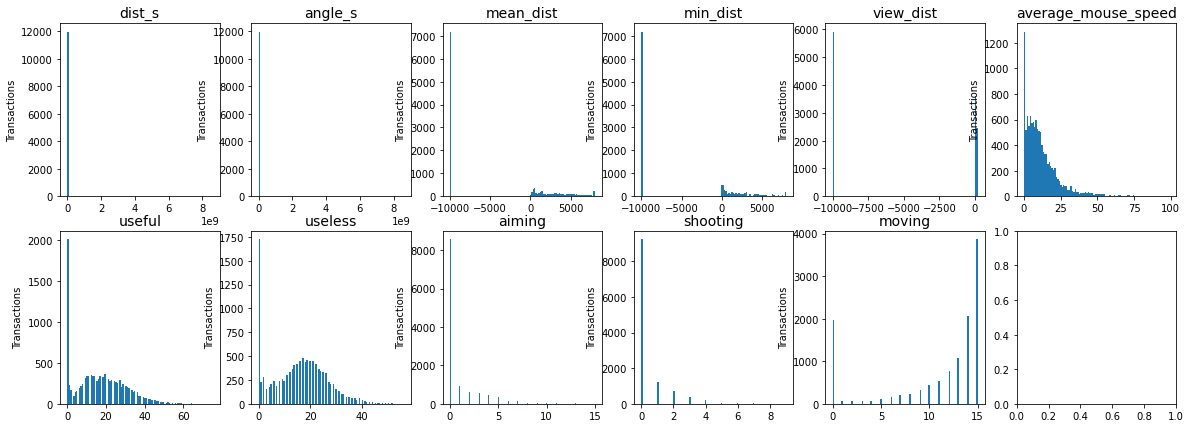

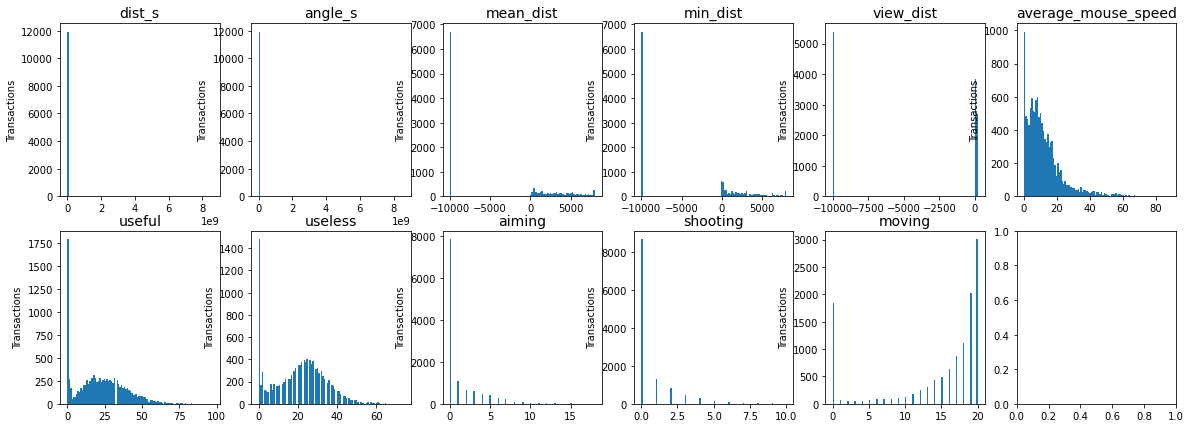

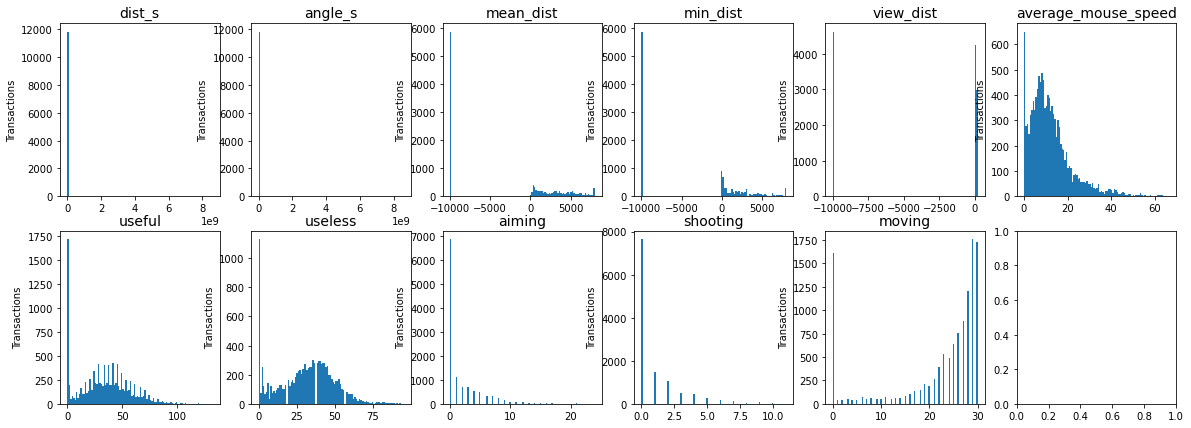

In [16]:
data = data_preparation_pipeline()
for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Check features"):
    fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(20, 7))
    for i in range(11):
        ax[i//6,i % 6].hist(X_train.iloc[:,i], bins=100)
        ax[i//6,i % 6].set_title(X_train.columns[i], fontsize=14)
        ax[i//6,i % 6].set_ylabel('Transactions')